In [4]:
##### 3-layer squared relu network is 7-homogenous in its weights. Therefore, a lot of time would be spent in
## the early directional convergence, since time required scale as O(1/\delta^5). Thus, we run projected gradient ascent
## on the NCF for some iterations so that the weights get close to a KKT point of the NCF and then use that as 
## the initialization for GD. The code below runs projected gradient ascent on the NCF


import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim.lr_scheduler as lr_scheduler


ct = 0

np.random.seed(11)
random.seed(11)
torch.manual_seed(11)

flg = 0
dx = 20;
dy = 1
N = 100;
torch.set_printoptions(precision=10)
torch.set_default_tensor_type(torch.DoubleTensor)
X = torch.randn(dx,N);         
X = torch.nn.functional.normalize(X,p=2,dim=0)      ### Input data

class sq_relu(nn.Module): 
    def __init__(self): 
        super(sq_relu, self).__init__() 

    def forward(self, x): 
        rl = x
        return rl*rl

# Define the neural network 
class Net(nn.Module): 
    def __init__(self, H1,H2): 
        super(Net, self).__init__() 
        self.fc1 = nn.Linear(dx,H1,bias=False)
        self.fc2 = nn.Linear(H1,H2,bias=False)
        self.fc3 = nn.Linear(H2,dy,bias=False)
        self.activation = sq_relu()

    def forward(self, x): 
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

### Defining Labels as the output of a smaller network
N_hid1_gt = 2
N_hid2_gt = 2
model_gt = Net(N_hid1_gt,N_hid1_gt)
init_u1_gt = torch.randn(dx,N_hid1_gt);
init_u2_gt = torch.randn(N_hid1_gt,N_hid2_gt);
init_u3_gt = torch.randn(N_hid2_gt,1);
nm_tot = torch.sqrt(torch.linalg.matrix_norm(init_u3_gt)**2+torch.linalg.matrix_norm(init_u2_gt)**2)
with torch.no_grad():
    model_gt.fc1.weight.data = init_u1_gt.clone().T
    model_gt.fc2.weight.data = init_u2_gt.clone().T/nm_tot
    model_gt.fc3.weight.data = init_u3_gt.clone().T/nm_tot

y = model_gt(X.T);   ## Labels

# # ############# Training

N_hid1 = 20     #### Number of hidden neurons
N_hid2 = 20

# Define the neural network 

model_ncf = Net(N_hid1,N_hid2)
learning_rate = 0.05
num_epochs = 50000
optimizer_ncf = torch.optim.SGD(model_ncf.parameters(), lr=learning_rate)

init_u1 = torch.randn(dx,N_hid1);
init_u2 = torch.randn(N_hid1,N_hid2);
init_u3 = torch.randn(N_hid2,dy);
nm_tot = torch.sqrt(torch.linalg.matrix_norm(init_u1)**2 + torch.linalg.matrix_norm(init_u2)**2 + torch.linalg.matrix_norm(init_u3)**2)
init_u1 = init_u1/nm_tot
init_u2 = init_u2/nm_tot
init_u3 = init_u3/nm_tot
dlt = 1
with torch.no_grad():
    model_ncf.fc1.weight.data = dlt*init_u1.clone().T       ### Unit norm initialization
    model_ncf.fc2.weight.data = dlt*init_u2.clone().T
    model_ncf.fc3.weight.data = dlt*init_u3.clone().T

epochs = 0
flg = 0
ct = 0
ls_st_ncf = torch.zeros(num_epochs)
dc_st_ncf = torch.zeros(num_epochs)
U1_st_ncf = torch.zeros(N_hid1,dx,num_epochs)
U2_st_ncf = torch.zeros(N_hid2,N_hid1,num_epochs)
U3_st_ncf = torch.zeros(dy,N_hid2,num_epochs)
###### PGA on the NCF
while epochs <= 38690:
    pred = model_ncf(X.T);
    loss_ncf = -torch.sum(pred*y)
    
    # Backpropagation
    optimizer_ncf.zero_grad()
    loss_ncf.backward(retain_graph=True)
    optimizer_ncf.step()
    
    


    ###### Normalizing the weights
    U1o = model_ncf.fc1.weight.data.detach().clone()
    U2o = model_ncf.fc2.weight.data.detach().clone()
    U3o = model_ncf.fc3.weight.data.detach().clone()
    nm_tot = torch.sqrt(torch.linalg.matrix_norm(U1o)**2 + torch.linalg.matrix_norm(U2o)**2+ torch.linalg.matrix_norm(U3o)**2)
    U1 = U1o/nm_tot
    U2 = U2o/nm_tot
    U3 = U3o/nm_tot

    with torch.no_grad():
        model_ncf.fc1.weight.data = U1
        model_ncf.fc2.weight.data = U2
        model_ncf.fc3.weight.data = U3
    #### Storing the normalized weights
    U1_st_ncf[:,:,epochs] = U1
    U2_st_ncf[:,:,epochs] = U2
    U3_st_ncf[:,:,epochs] = U3

    epochs = epochs+1


tensor(-0.9255849972)

In [5]:
import torch.optim.lr_scheduler as lr_scheduler

model = Net(N_hid1,N_hid2)

learning_rate = 0.2
num_epochs = 300000
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=40000, gamma=0.05)
loss_fn = nn.MSELoss(reduction='sum')

dlt = 0.1
with torch.no_grad():
    model.fc1.weight.data = dlt*U1_st_ncf[:,:,38690]     ##### Small initialization of weights
    model.fc2.weight.data = dlt*U2_st_ncf[:,:,38690]      ### Ui_st_ncf[:,:,38690] denotes the result of 
    model.fc3.weight.data = dlt*U3_st_ncf[:,:,38690]      ### running PGA on NCF for 38690 iterations

epochs = 0
nm_st = torch.zeros(num_epochs,1)
ls_st = torch.zeros(num_epochs,1)
dc_st = torch.zeros(num_epochs,1)
U1_st = torch.zeros(N_hid1,dx,num_epochs)
U2_st = torch.zeros(N_hid2,N_hid1,num_epochs)
U3_st = torch.zeros(dy,N_hid2,num_epochs)
flg = 0
pred = model(X.T);
loss = loss_fn(pred,y)
lo = loss.item()
ct = 0

while epochs < num_epochs:

#     ###### Storing loss
    ls_st[epochs] = loss.item()

    # Backpropagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    ##### Storing the weights
    U1 = model.fc1.weight.data.detach()
    U2 = model.fc2.weight.data.detach()
    U3 = model.fc3.weight.data.detach()
    U1_st[:,:,epochs] = U1
    U2_st[:,:,epochs] = U2
    U3_st[:,:,epochs] = U3

    pred = model(X.T);
    loss = loss_fn(pred,y)

    if epochs%20000==0:
        print(loss.item())       ##### Printing loss after every 20000 epochs
    if epochs<100000:
        scheduler.step()         #### Changing step-sizes
    if epochs == 250000:
        for g in optimizer.param_groups:
            g['lr'] = 0.0003    #### Fixing step-sizes
    epochs = epochs+1
#### The loss landscape is quite complex. If we choose small step-size then algorithm takes too long in the early
### stages. If we choose too high then it diverges after escaping from the origin. So, in the beginning we choose
### large step size and then decrease it as the training progresses

388.9445288044478
388.94452876348646
388.94452730498074
388.9445256456811
388.944512166717
388.94450910957903
388.9445049446574
388.9444990022689
388.9444899761427
388.94447497795306
388.94444630500027
388.944375734429
388.9440520840239
17.00011030560319
8.520798304695465
tensor(0.)


Text(263510, 20, '(II)')

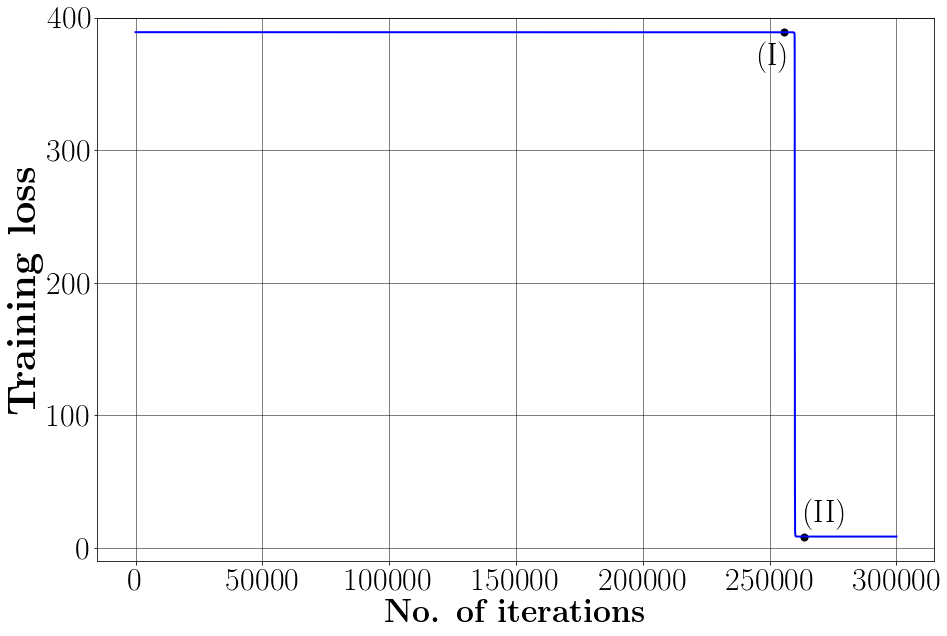

In [6]:
###### Plot of the evolution of loss with iterations

import math as m
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['text.usetex']=True
# plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 32}
matplotlib.rc('font', **font)
st_itr = 0
end_itr = 300000
stp = 10
ep1 = 255510
ep2 = 263510

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel(r'\textbf{No. of iterations}')
ax.plot(np.arange(st_itr,end_itr),ls_st[st_itr:end_itr],color='b', linestyle='-',linewidth = 2)
ax.set_ylabel(r'\textbf{Training loss}',rotation='vertical',fontsize=40)
ax.grid(b=True, which='major', color='k', linestyle='-',linewidth = 0.5)
ax.scatter(ep1,ls_st[ep1],50,'k')
ax.scatter(ep2,ls_st[ep2],50,'k')
ax.set_ylim([-10,400])

W, H = ep1, 365
ax.text(W-10000, H, r'(I)')
W, H = ep2, 20
ax.text(W, H, r'(II)')




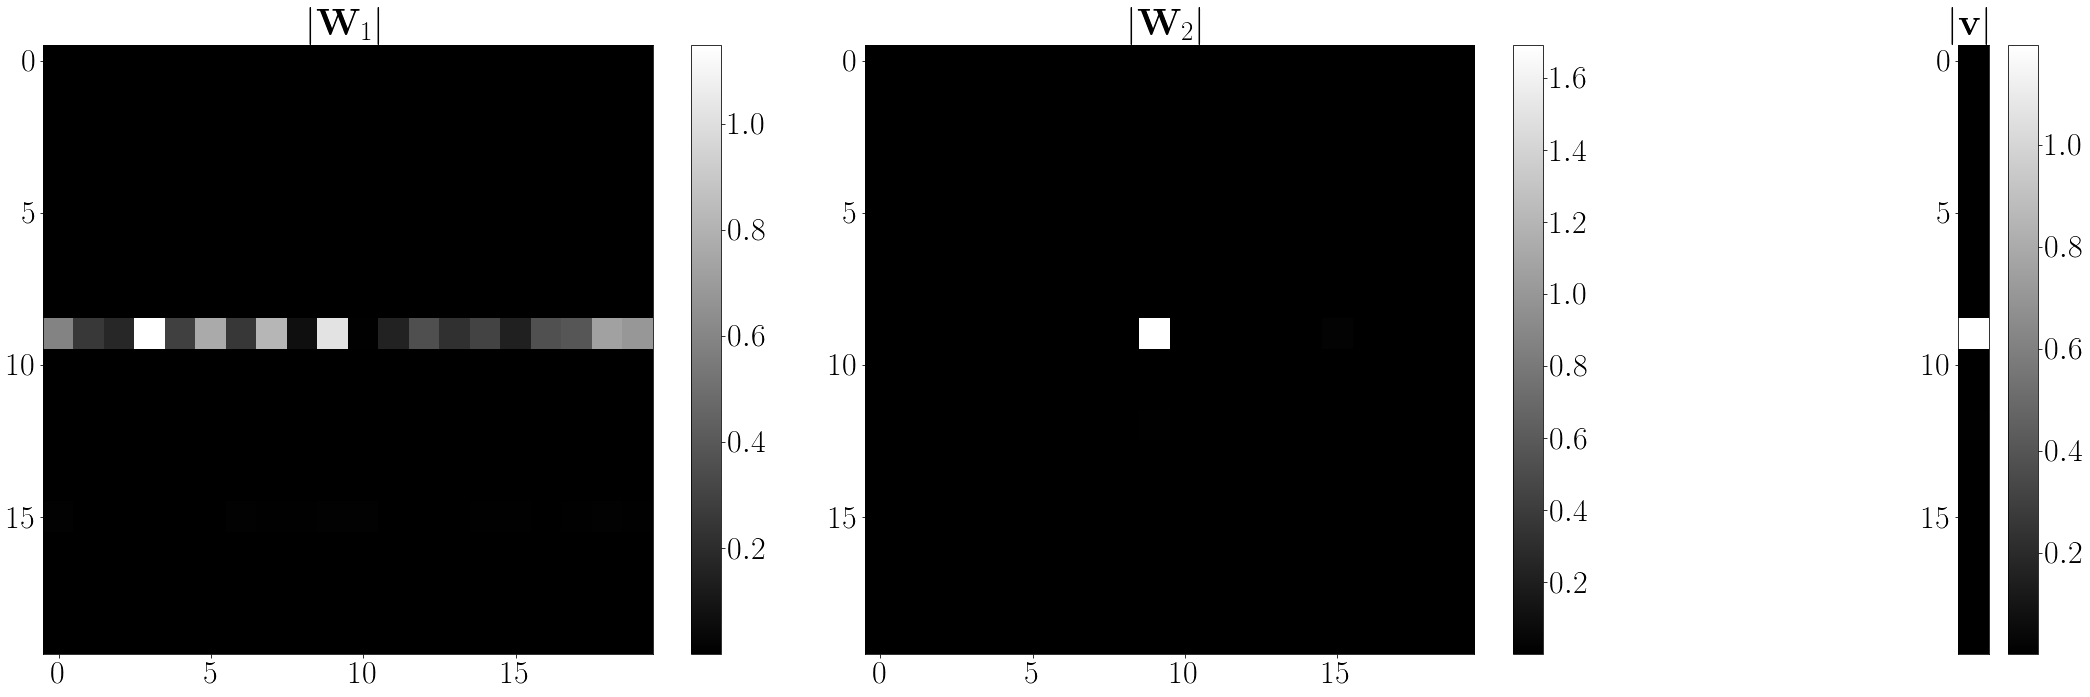

In [7]:
### Plotting weights at iteration 263510, just after reaching the saddle point


yticks = np.arange(0, 20, 5)  # Example: Show y-ticks at intervals of 2


fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 1])  # First subplot twice as wide as second

# Plot the first image
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(torch.abs(U1_st[:, :, 263510]), cmap='gray')
ax1.set_title(r'$|\mathbf{W}_1|$')
ax1.set_yticks(yticks)
fig.colorbar(im1, ax=ax1)

# Plot the second image
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(torch.abs(U2_st[:, :, 263510]), cmap='gray')
ax2.set_title(r'$|\mathbf{W}_2|$')
ax2.set_yticks(yticks)
fig.colorbar(im2, ax=ax2)

# Plot the third image
ax3 = fig.add_subplot(gs[2])
im3 = ax3.imshow(torch.abs(U3_st[:, :, 263510].T), cmap='gray')
ax3.set_title(r'$|\mathbf{v}|$')
ax3.set_xticks([])  # Remove x-axis ticks for the second plot
ax3.set_yticks(yticks)
fig.colorbar(im3, ax=ax3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

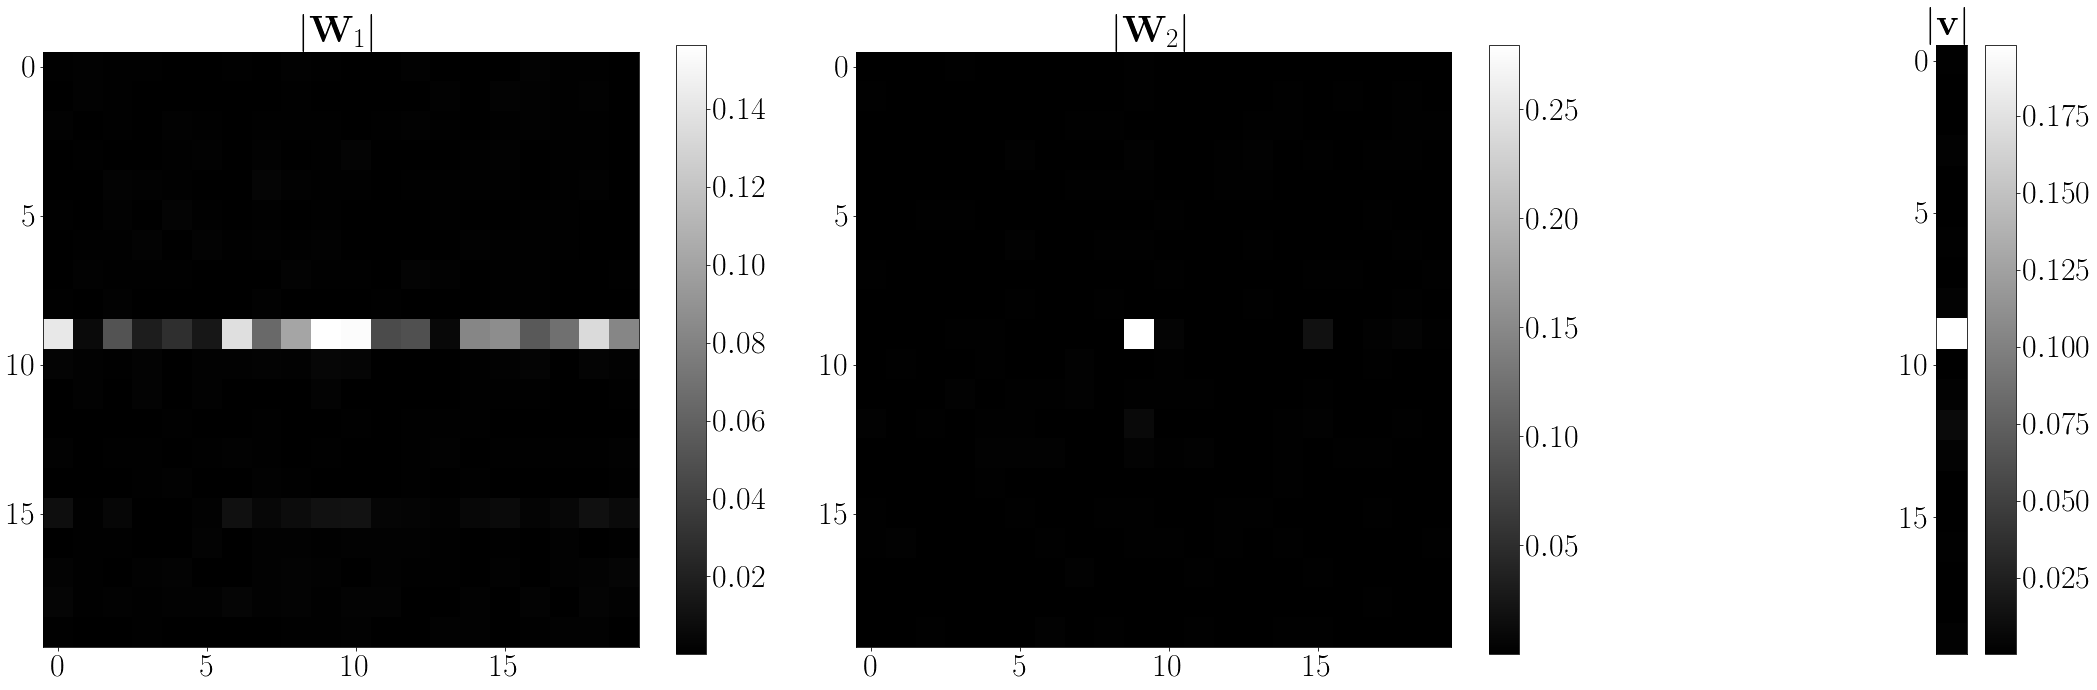

In [8]:
### Plotting weights at iteration 255510, just before escaping the origin

yticks = np.arange(0, 20, 5)  # Example: Show y-ticks at intervals of 2


fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 1])  # First subplot twice as wide as second

# Plot the first image
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(torch.abs(U1_st[:, :, 255510]), cmap='gray')
ax1.set_title(r'$|\mathbf{W}_1|$')
ax1.set_yticks(yticks)
fig.colorbar(im1, ax=ax1)

# Plot the second image
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(torch.abs(U2_st[:, :, 255510]), cmap='gray')
ax2.set_title(r'$|\mathbf{W}_2|$')
ax2.set_yticks(yticks)
fig.colorbar(im2, ax=ax2)

# Plot the third image
ax3 = fig.add_subplot(gs[2])
im3 = ax3.imshow(torch.abs(U3_st[:, :, 255510].T), cmap='gray')
ax3.set_title(r'$|\mathbf{v}|$')
ax3.set_xticks([])  # Remove x-axis ticks for the second plot
ax3.set_yticks(yticks)
fig.colorbar(im3, ax=ax3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()